In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Data

In [2]:
# Get the absolute path to the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) #change when running in a different directory
src_path = os.path.join(project_root, "src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)

from create_Dataframe import createDataframe as create_df

merged_data_summer = create_df('summer')

/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Global variables

In [3]:
price = merged_data_summer["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_summer['Inflexible_Demand_(kWh)'].values
Time_interval = len(price)  # Total time interval in hours

# Initiate gurobi model
model = gp.Model("automated_demand_response")
model.update()

Set parameter Username
Set parameter LicenseID to value 2653942
Academic license - for non-commercial use only - expires 2026-04-17


### Dishwasher

In [4]:
# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval)# - duration + 1)
dishwasher_start = model.addVars(Time_interval, vtype=GRB.BINARY, name="start_dw")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dw")

# When dishwasher is on, it must be running -> dw_start is 1 -> binary_dishwasher at the same time + duration_dw is 1 
for t, k in itertools.product(range(len(start_times)-duration + 1), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")
for t in range(len(start_times) - duration):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration + 1)) <= 3, name=f"dw_max_three_hours_on_{t}")

# Enforce min 1 run per day
# adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * hours_per_day, (d + 1) * hours_per_day)) == 1,
                name=f"min_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
# multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
# this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_dw_{t}")
    
# constraint that the dishwasher may not start in the last 3 hours of the entire time interval
for t in range(Time_interval - duration, Time_interval):
    model.addConstr(dishwasher_start[t] == 0, name=f"no_start_in_last_hours_{t}")
model.update()

### Washing Machine

In [5]:
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

# Binary start variables: 1 if washing machine starts at hour t
start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if washing machine is on at hour t
binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 
for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")
for t in range(len(start_times_wm)-1):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")

# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
# adds up all possible start times of the washing machine in a single week and '>= 1' day ensures that the washing machine has to run 4 times per week
hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7 -1)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")

# Enforce minimum gap (1 hour) between two starts
for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_WM_summer'] = 0  # Initialize with 0

#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 1
    else: 
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 0
        
model.addConstrs((binary_wm[t] <= merged_data_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")

model.update()

### Dryer 

In [6]:
# dryer properties
duration_dryer = 2  # hours of operation
max_gap_wm_dryer = 2  # hours between washing machine end and dryer start
power_dryer = 3  # kW during operation -> should be double checked

# Binary start variables: 1 if dryer starts at hour t
start_times_dryer = range(Time_interval - duration_dryer + 1)
dryer_start = model.addVars(start_times_dryer, vtype=GRB.BINARY, name="start_dryer")

# Binary on variables: 1 if dryer is on at hour t
binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# When dryer is on, it must be running -> dryer_start is 1 -> binary_dryer at the same time + duration_dryer is 1 
for t, k in itertools.product(range(len(start_times_dryer)), range(duration_dryer)):
    model.addConstr(binary_dryer[t + k] >= dryer_start[t], name=f"dryer_{t}_{k}")
for t in range(len(start_times_dryer)-1):
    model.addConstr(gp.quicksum(binary_dryer[t + k] for k in range(duration_dryer+1)) <= duration_dryer, name=f"dryer_max_two_hours_on_{t}")

# Enforce that the dryer starts within max_gap_wm_dryer hours after the washing machine ends
for t in range(len(dryer_start)-max_gap_wm_dryer-duration_wm):
    model.addConstr(gp.quicksum(dryer_start[t + offset + duration_wm] for offset in range(0, max_gap_wm_dryer + 1)) >= wm_start[t],
                name=f"max_gap_after_washing_dryer_{t}")

#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_dryer_summer'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 1
    else: 
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 0

model.addConstrs((binary_dryer[t] <= merged_data_summer['Allowed_dryer_summer'][t] for t in range(len(binary_dryer))), name="allowed_dryer_summer")

model.update()

### EV - G2V

In [7]:
# EV properties
min_power_ev = 1 #kW, minimum power to charge the EV
max_power_ev = 10 #kW, maximum power to charge the EV
kwh_per_km = 0.2  # kWh per km driven
max_capacity_ev = 70 #kWh

###Variables
#state of charge of the EV at each time step
soc_ev = model.addVars(Time_interval,lb=0, ub=max_capacity_ev, vtype=GRB.CONTINUOUS, name="soc_ev")
#how much power is being charged at each time step
charging_ev = model.addVars(Time_interval,lb=0, ub=max_power_ev, vtype=GRB.CONTINUOUS, name="charging_lvl_ev")
#binary variable to indicate if the EV is being charged at each time step
binary_ev = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_ev")

# Enforce SoC at 7:00 every day (hour 7 of each day)
for d in range(Time_interval // 24):
    t = d * 24 + 7  # 7:00 each day
    if t < Time_interval:
        model.addConstr(soc_ev[t] >= 0.8*max_capacity_ev, name=f"ev_soc_7am_day_{d}")

# car can only charge if it is at home
model.addConstrs((binary_ev[t] <= merged_data_summer['ev_at_home_binary'][t] for t in range(len(binary_ev))), name="allowed_ev_summer")

# if car is at home, it can charge, but not more than the maximum power
# and if it is charging, it must be charging at least the minimum power
model.addConstrs((charging_ev[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * binary_ev[t] for t in range(Time_interval)), name="max_power_ev")
model.addConstrs((charging_ev[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * binary_ev[t] for t in range(Time_interval)), name="min_power_ev")

# Constrain ev storage
initial_soc_ev = 20
model.addConstr(soc_ev[0] == initial_soc_ev, name="ev_soc_initial")
model.addConstrs((soc_ev[t] == soc_ev[t-1] + charging_ev[t-1] - merged_data_summer['distance_driven'][t-1] * kwh_per_km for t in range(1,Time_interval)),name="ev_soc_update")

model.update()

### PV

In [ ]:
# for power produced with the PV system, the price is 0 
# Total power consumption including fixed and dishwasher
total_load = {
    t: merged_data_summer['Inflexible_Demand_(kWh)'][t] +
       power_dishwasher * binary_dishwasher[t] +
       power_wm * binary_wm[t] + 
       power_dryer * binary_dryer[t] + 
       charging_ev[t]
    for t in range(Time_interval)
}

# Binary variable to indicate if PV production is maxed out
pv_maxed_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="pv_maxed")

# Choose M large enough to cover max difference between pv and load
M = 10000

# If demand is higher than PV production
unmet   = model.addVars(Time_interval, lb=0.0, name="unmet_load")

# If PV production is higher than demand, the excess is curtailed
curtail = model.addVars(Time_interval, lb=0.0, name="curtail_pv")

# Add constraints for PV production, unmet load, and curtailment
for t in range(Time_interval):
    pv = merged_data_summer['PV_energy_production_kWh'][t]
    load = total_load[t]
    
    # Binary switch: if PV > load → binary = 0; else 1
    model.addConstr(pv - load + unmet[t] - curtail[t] == 0, name=f"pv_load_balance_{t}")
    model.addConstr(curtail[t] <= (1-pv_maxed_binary[t]) * M , name=f"curtail_pv_{t}_2")
    model.addConstr(unmet[t] <= pv_maxed_binary[t] * M, name=f"unmet_load_{t}_2")

model.update()

### Peak Price 
If everyone implements this optimization, the price will have to be higher at peak times 

In [11]:
ε = 1e-3
wanted_steps = 6
max_demand = max(inflexible_demand) + power_dishwasher + power_wm + power_dryer + max_power_ev
levels = np.arange(0, max_demand/7*6 + ε, max_demand/((wanted_steps - 1)))
levels = np.append(levels, max_demand * 1.5 + 5)  # Ensure coverage

#multiplier for penalty costs per level increasing by 0.1 per level
multiplier_per_level = [0.003 * i for i in range(len(levels)-1)]
M_price = max_demand + 10

# Binary indicators per level per timestep
level_bin = [
    [model.addVar(vtype=GRB.BINARY, name=f"level_bin[{t},{i}]") for i in range(len(levels)-1)]
    for t in range(Time_interval)
]

# Integer index of active level
demand_level = [
    model.addVar(lb=0, ub=len(levels) - 1, vtype=GRB.INTEGER, name=f"demand_level[{t}]")
    for t in range(Time_interval)
]

# Total demand per timestep
net_demand = model.addVars(Time_interval, lb=0, ub=max_demand, vtype=GRB.CONTINUOUS, name="net_demand")

# Constraint: calculate total demand
for t in range(Time_interval):
    model.addConstr(
        net_demand[t] ==
        unmet[t], name=f"net_demand_from_grid_calc_{t}"
    )

# Constraint: only one level active at a time
for t in range(Time_interval):
    model.addConstr(gp.quicksum(level_bin[t]) == 1, name=f"one_level_active_{t}")

# Constraint: bind net_demand to its level using Big-M
for t in range(Time_interval):
    for i in range(len(levels) - 1):
        model.addConstr(
            net_demand[t] >= levels[i] - (1 - level_bin[t][i]) * M_price,
            name=f"lower_bound_level_{t}_{i}"
        )
        model.addConstr(
            net_demand[t] <= levels[i + 1] - ε + (1 - level_bin[t][i]) * M_price,
            name=f"upper_bound_level_{t}_{i}"
        )
    # Calculate demand_level from binary selection
    model.addConstr(
        demand_level[t] == gp.quicksum(i * level_bin[t][i] for i in range(len(levels)-1)),
        name=f"demand_level_calc_{t}"
    )

#generate penalty costs for each level that depend on a const and a linear term
penalty_per_level = [multiplier_per_level[i] * levels[i] for i in range(len(levels)-1)]

# Penalty term as an expression
penalty_cost = gp.quicksum(
    penalty_per_level[i] * level_bin[t][i]
    for t in range(Time_interval)
    for i in range(len(levels)-1)
)

model.update()

### Objective Function and Optimization

In [12]:
# Electricity cost
electricity_cost = gp.quicksum(price[t] * unmet[t] for t in range(Time_interval))

# Full objective: cost + penalty
model.setObjective(electricity_cost + penalty_cost, GRB.MINIMIZE)

# Optimize
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 32280 rows, 17470 columns and 88109 nonzeros
Model fingerprint: 0x8bf75d7d
Variable types: 4032 continuous, 13438 integer (12094 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+04]
  Objective range  [2e-03, 2e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e-04, 1e+04]

MIP start from previous solve produced solution with objective 25.4266 (0.11s)
Loaded MIP start from previous solve with objective 25.4266

Presolve removed 26460 rows and 12069 columns
Presolve time: 1.22s
Presolved: 5820 rows, 5401 columns, 29572 nonzeros
Variable types: 890 continuous, 4511 integer (4511 binary)

Root relaxation: objective 2.200330e+01, 3314 iterations, 0.09 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds

### Save Results

In [ ]:
# Prepare results DataFrame
results_df = merged_data_summer.copy()
results_df['Total_Demand'] = [total_demand[t].X for t in range(len(results_df))]
results_df['Dishwasher_Start'] = [dishwasher_start[t].X if t in start_times else 0 for t in range(len(results_df))]
results_df['Dishwasher_On'] = [binary_dishwasher[t].X for t in range(len(results_df))]
results_df['Washing_Machine_Start'] = [wm_start[t].X if t in start_times_wm else 0 for t in range(len(results_df))]
results_df['Washing_Machine_On'] = [binary_wm[t].X for t in range(len(results_df))]
results_df['Dryer_Start'] = [dryer_start[t].X if t in start_times_dryer else 0 for t in range(len(results_df))]
results_df['Dryer_On'] = [binary_dryer[t].X for t in range(len(results_df))]
results_df['EV_SOC'] = [soc_ev[t].X for t in range(len(results_df))]
results_df['EV_Charging'] = [charging_ev[t].X for t in range(len(results_df))]
results_df['EV_On'] = [binary_ev[t].X for t in range(len(results_df))]
results_df['Unmet'] = [unmet[t].X for t in range(len(results_df))]
results_df['Demand_Level'] = [demand_level[t].X for t in range(len(results_df))]
results_df['Penalty'] = [
    sum(
        penalty_per_level[i] * level_bin[t][i].X
        for i in range(len(penalty_per_level))
    )
    for t in range(len(results_df))
]
results_df['Electricity_Cost'] = [
    price[t] * unmet[t].X for t in range(len(results_df))
]
results_df['Total_Price'] = [
    results_df['Electricity_Cost'][t] + results_df['Penalty'][t]
    for t in range(len(results_df))
]
# Save to CSV
results_csv_path = os.path.join(project_root, "results_case_2_summer.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

Results saved to /Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/results_case_2_summer.csv


### Print results

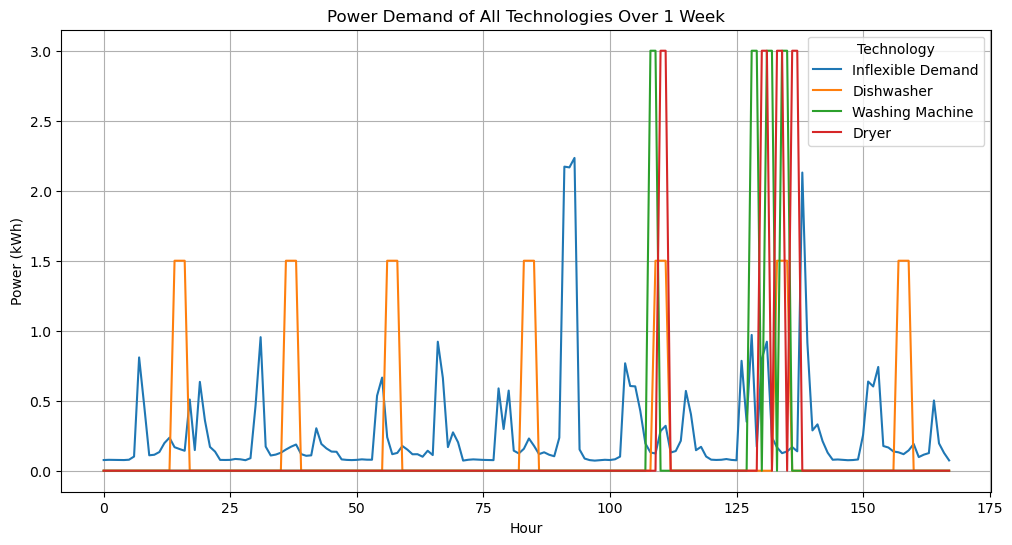

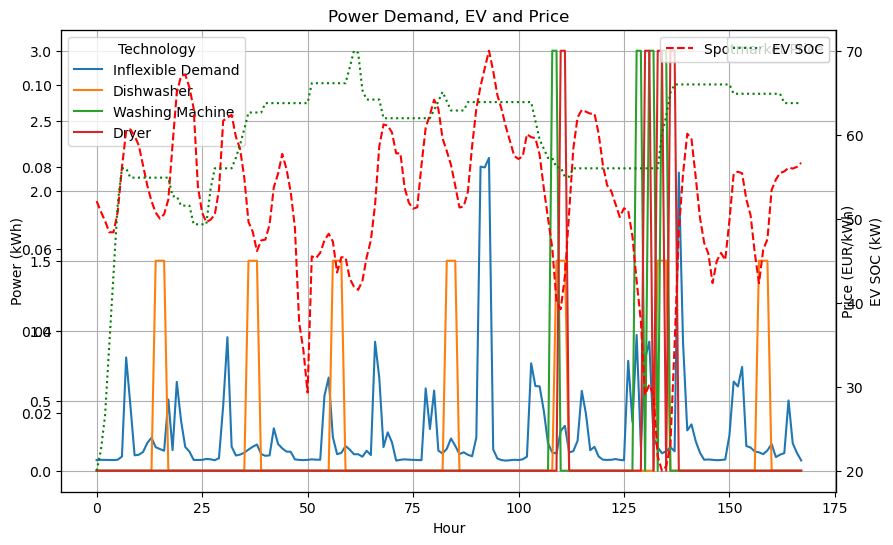

In [26]:
# Define the time range for one week
time_range = range(0, 24 * 7 )  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Inflexible Demand': merged_data_summer['Inflexible_Demand_(kWh)'][:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range],
    'Dryer': [power_dryer * binary_dryer[t].X for t in time_range],
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')

# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology')
plt.title('Power Demand of All Technologies Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kWh)')
plt.legend(title='Technology')
plt.grid(True)
plt.show()

# Power demand of all technologies
plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Plot power demand (left y-axis)
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology', ax=ax1)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power (kWh)')
ax1.legend(title='Technology', loc='upper left')
ax1.grid(True)

# Create a second y-axis for the price
ax2 = ax1.twinx()
sns.lineplot(
    data=pd.DataFrame({'Hour': list(time_range), 'Price': merged_data_summer['Spotmarket_(EUR/kWh)'][:len(time_range)]}),
    x='Hour', y='Price', color='red', label='Spotmarket Price', linestyle='--', ax=ax2
)
ax2.set_ylabel('Price (EUR/kWh)')

ax3 = ax2.twinx()
sns.lineplot(
    data=pd.DataFrame({'Hour': list(time_range), 'EV SOC': [soc_ev[t].X for t in time_range]}),
    x='Hour', y='EV SOC', color='green', label='EV SOC', linestyle=':', ax=ax3
)
ax3.set_ylabel('EV SOC (kW)')

plt.title('Power Demand, EV and Price')
plt.show()

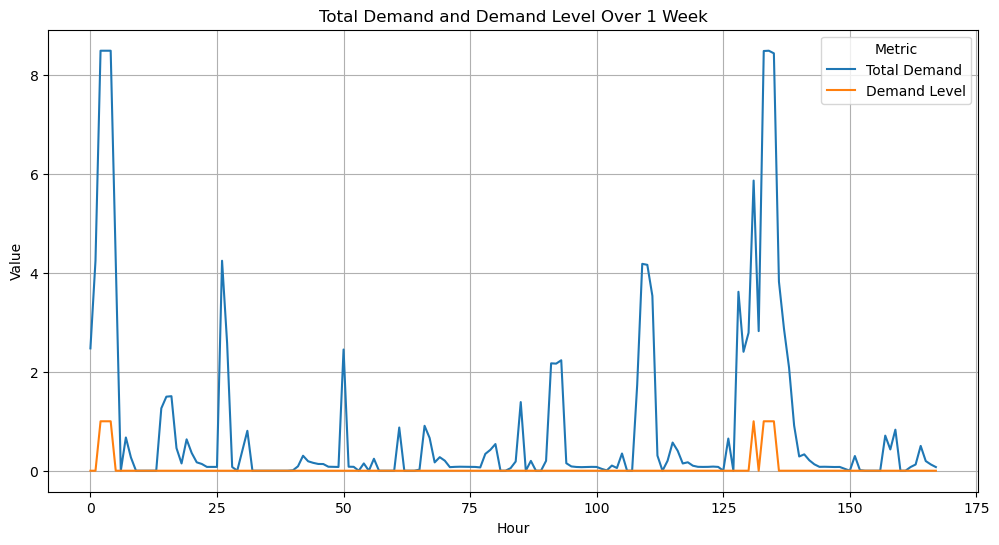

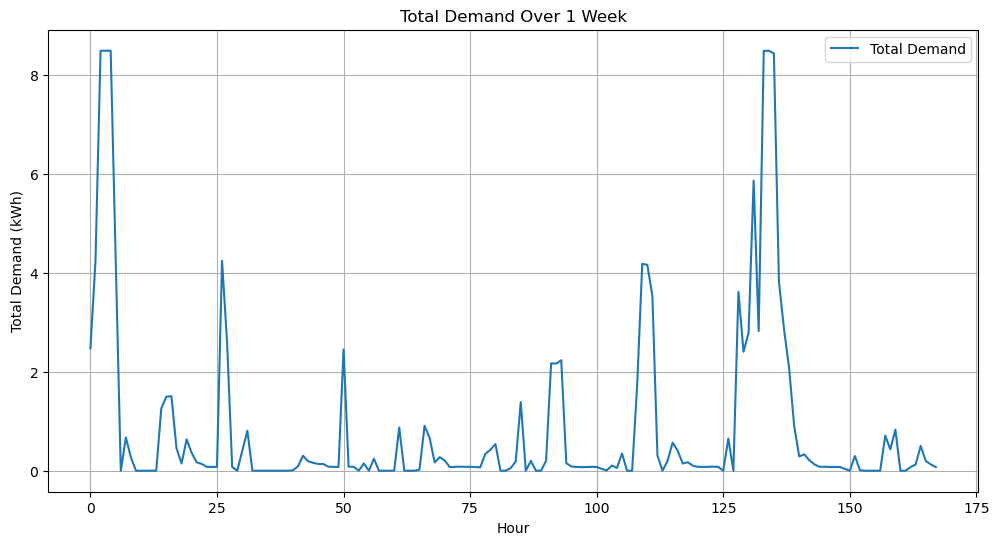

In [27]:
#plot demand and demnd level
# Create a DataFrame for the demand and demand level
data_demand = pd.DataFrame({
    'Hour': list(time_range),
    'Total Demand': [total_demand[t].X for t in time_range],
    'Demand Level': [demand_level[t].X for t in time_range]
})
# Melt the data for easier plotting
data_demand_melted = data_demand.melt(id_vars='Hour', var_name='Metric', value_name='Value')
# Plot 2: Total demand and demand level
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_demand_melted, x='Hour', y='Value', hue='Metric')
plt.title('Total Demand and Demand Level Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.grid(True)
plt.show()

#plot only total demand
plt.figure(figsize=(12, 6))
sns.lineplot(x=list(time_range), y=[total_demand[t].X for t in time_range], label='Total Demand')
plt.title('Total Demand Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Total Demand (kWh)')
plt.legend()
plt.grid(True)
plt.show()

